In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


 观察数据情况。

In [2]:
## 载入数据。
data = pd.read_csv("../input/heart.csv")
data.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [3]:
## 将sex中的0 赋值成 female；1 赋值成 male
##data['sex'][data['sex'] == 0] = 'female'
##data['sex'][data['sex']==1] = 'male'

In [4]:
## 获取sex中不同取值的统计个数
data['sex'].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [5]:
## 展示所有数值类型字段的统计信息 均值 方差 均方差 分位数等
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
## 数据集准备及预处理
print("Before drop target : {}".format(data.shape))
y = data['target']
y.value_counts() # 展示数据的统计值
data.drop(columns=['target'], inplace=True)
print("After drop target : {}".format(data.shape))
'''data_dummies = pd.get_dummies(data) ## one_hot 编码 ，虚拟变量.只对分类变量有效，对数值型连续变量无效
x = data_dummies.values
print("Features after get_dummies: \n", list(data_dummies.columns))
'''
x = data.values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

## 数据缩放
##scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Before drop target : (303, 14)
After drop target : (303, 13)


In [7]:
## 梯度提升回归树  GBRT
gbrt = GradientBoostingClassifier(random_state=0)

## 网格搜索算法查询最优参数（n_estimators 树个数；learning_rate 学习率； max_depth 树深度 ）
params_gbrt = [{
    'n_estimators':[30,50,40,20],
    'learning_rate':[0.01,0.1,1,0.001],
    'max_depth':[5,2,3,4]
}]

gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=6)
gbrt_grid.fit(X_train, y_train)
#gbrt.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
print("Best parameters: ", gbrt_grid.best_params_)
print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(X_test, y_test)))

Best cross-validation score: 0.84
Best parameters:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
Accuracy on training set:0.939
Accuracy on test set:0.811


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy on test set:0.811
f1 score of GBRT: 0.82
Classification report of GBRT: 
              precision    recall  f1-score   support

  no disease       0.81      0.80      0.80        59
     disease       0.81      0.83      0.82        63

   micro avg       0.81      0.81      0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



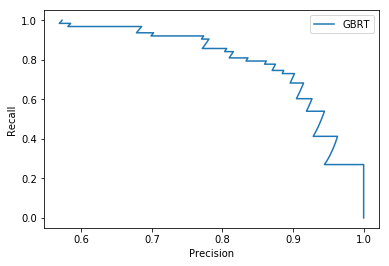

In [8]:
## 使用gbrt的最优参数构建模型 并评估模型性能
best_params_gbrt = gbrt_grid.best_params_
gbrt_model = GradientBoostingClassifier(**best_params_gbrt)
gbrt_model.fit(X_train, y_train)
print("Accuracy on test set:{:.3f}".format(gbrt_model.score(X_test, y_test)))

gbrt_pred = gbrt_model.predict(X_test)
## f1 score
print("f1 score of GBRT: {:.2f}".format(f1_score(y_test,gbrt_pred)))
## 模型评估报告
print("Classification report of GBRT: \n{}".format(classification_report(y_test, gbrt_pred, 
                                        target_names=["no disease", "disease"])))
gbrt_proba = gbrt_model.predict_proba(X_test)
## 计算GBRT的准确度和召回率
precision_gbrt, recall_gbrt,thresholds_gbrt = precision_recall_curve(y_test, gbrt_proba[:,1])
plt.plot(precision_gbrt, recall_gbrt, label="GBRT")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc=1)
plt.show()

In [9]:
from sklearn.metrics import confusion_matrix
## 计算混淆矩阵
confusion_gbrt = confusion_matrix(y_test, gbrt_pred)
print("Confusion matrix of GBRT:\n {}".format(confusion_gbrt))

Confusion matrix of GBRT:
 [[47 12]
 [11 52]]


Accuracy of random forest model is 0.81
[0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0
 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0
 0 0 0 0 0 1 0 1 0 1 1]
0.8114754098360656
f1 score : 0.82
classification report: 
              precision    recall  f1-score   support

  no disease       0.81      0.80      0.80        59
     disease       0.81      0.83      0.82        63

   micro avg       0.81      0.81      0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


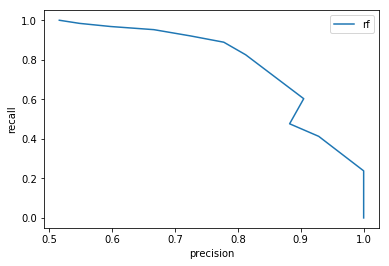

In [10]:
## 随机森林算法建模
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
print("Accuracy of random forest model is {:.2f}".format(rf.score(X_test, y_test)))
rf.feature_importances_
proba = rf.predict_proba(X_test)
#log_proba = rf.predict_log_proba(X_test)
print(rf.predict(X_test))
pred_rf = rf.predict(X_test)
print((pred_rf == y_test).sum() / y_test.size)

## 计算随机森林的准确度和召回率
precision_rf, recall_rf,thresholds_rf = precision_recall_curve(y_test, proba[:,1])
plt.plot(precision_rf, recall_rf, label="rf")
plt.xlabel("precision")
plt.ylabel("recall")
plt.legend(loc=1)

## f1 score
print("f1 score : {:.2f}".format(f1_score(y_test,pred_rf)))
## 模型评估报告
print("classification report: \n{}".format(classification_report(y_test, pred_rf, 
                                        target_names=["no disease", "disease"])))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best cross-validation score: 0.85
Best parameters:  {'max_depth': 6, 'max_features': 4, 'n_estimators': 60}
Test score: 0.82
f1 score : 0.83
classification report: 
              precision    recall  f1-score   support

  no disease       0.84      0.78      0.81        59
     disease       0.81      0.86      0.83        63

   micro avg       0.82      0.82      0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122



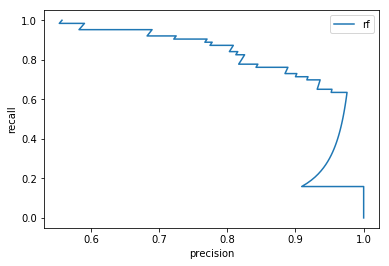

In [11]:
## 使用网格搜索 查找最优参数
param_grid = [{'n_estimators':[20,60,100],
               'max_features':[4,6,8,10],
               'max_depth':[6,10,20,30]}]
#kfold = KFold(n_splits=4, shuffle=True, random_state=66)
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5) ## cv=kfold
grid_search.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best parameters: ", grid_search.best_params_)

print("Test score: {:.2f}".format(grid_search.score(X_test, y_test)))

proba_grid = grid_search.predict_proba(X_test)
## 计算随机森林的准确度和召回率
precision_rf, recall_rf,thresholds_rf = precision_recall_curve(y_test, proba_grid[:,1])
plt.plot(precision_rf, recall_rf, label="rf")
plt.xlabel("precision")
plt.ylabel("recall")
plt.legend(loc=1)
pred_grid = grid_search.predict(X_test)
## f1 score
print("f1 score : {:.2f}".format(f1_score(y_test,pred_grid)))
## 模型评估报告
print("classification report: \n{}".format(classification_report(y_test, pred_grid, 
                                        target_names=["no disease", "disease"])))

In [12]:
# shape属性 返回一个元组 记录数据的行数 列数 
data.shape
# 取数据的行数 shape[0]
# 取数据的列数（即数据特征个数） shape[1]

##print("数据的")
##data.columns

(303, 13)

f1 score : 0.83
classification report: 
              precision    recall  f1-score   support

  no disease       0.84      0.78      0.81        59
     disease       0.81      0.86      0.83        63

   micro avg       0.82      0.82      0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122



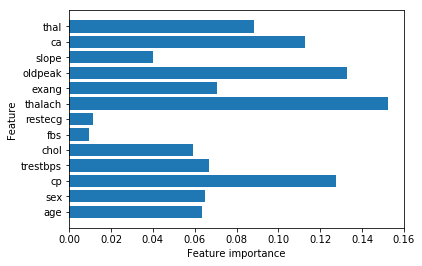

In [13]:
## 计算特征重要性
'''
data 是DataFrame 类型的源数据
model 是模型实例
'''
def plot_feature_importances(data, model):
    n_features = data.shape[1]
    plt.barh(range(n_features),model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
params = grid_search.best_params_ ##使用网格搜索的最优参数
model = RandomForestClassifier().set_params(**params)
model.fit(X_train, y_train)
pred_grid = grid_search.predict(X_test)
## f1 score
print("f1 score : {:.2f}".format(f1_score(y_test,pred_grid)))
## 模型评估报告
print("classification report: \n{}".format(classification_report(y_test, pred_grid, 
                                        target_names=["no disease", "disease"])))
plot_feature_importances(data, model)

AUC of Random Forest: 0.897


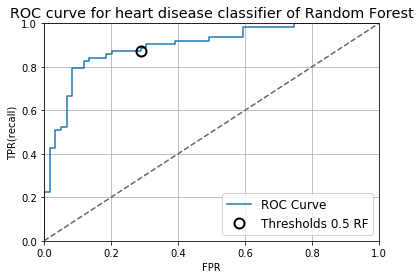

In [14]:
##绘制ROC曲线 计算AUC
from sklearn.metrics import roc_curve,auc,roc_auc_score
import numpy as np

proba_rf =  model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba_rf)

#model.predict_proba(X_test)[:,1]
#y_test.values
fig, ax = plt.subplots()
#ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".4")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for heart disease classifier of Random Forest')

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.legend(loc=4)
plt.grid(True)
close_default_rf = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o',markersize=10, 
         label='Thresholds 0.5 RF', fillstyle="none", c='k',mew=2)
plt.legend(loc=4)
rf_auc = roc_auc_score(y_test,  proba_rf)
print("AUC of Random Forest: {:.3f}".format(rf_auc))
## print(auc(fpr, tpr)) ## 使用auc函数亦可得到roc曲线下面积

由于都是数值型变量，故而无法使用one-hot编码，构造虚拟变量，需要对数据进行分类转换。